In [1]:
%matplotlib inline

import numpy as np

import matplotlib.pyplot as plt

from functools import partial

import menpo.io as mio
from menpo.landmark import labeller, ibug_face_66
from menpo.image import Image
from menpo.feature import no_op, fast_dsift
from menpo.visualize import visualize_images

from menpofit.visualize import visualize_fitting_results

from alabortcvpr2015.aam import (
    GlobalAAMBuilder, GlobalAAMFitter, 
    PartsAAMBuilder, PartsAAMFitter,
    AIC, PIC)
from alabortcvpr2015.clm import CLMBuilder, CLMFitter, RLMS

# Load training data

In [269]:
training_images = []
for i in mio.import_images('/data/PhD/DataBases/faces/lfpw/trainset/', verbose=True, 
                           max_images=None):
    
    i = i.rescale_landmarks_to_diagonal_range(100)
    i.crop_to_landmarks_proportion_inplace(0.5)
    labeller(i, 'PTS', ibug_face_66)
#     if i.n_channels == 3:
#         i = i.as_greyscale(mode='average')
    training_images.append(i)

- Loading 811 assets: [====================] 100%

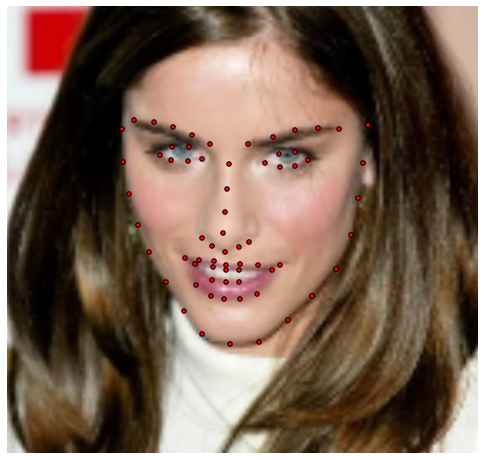

In [270]:
visualize_images(training_images)

# Load test data

In [271]:
test_images = []
for i in mio.import_images('/data/PhD/DataBases/faces/afw', verbose=True, 
                           max_images=10):
    
    i = i.rescale_landmarks_to_diagonal_range(100)
    i.crop_to_landmarks_proportion_inplace(0.5)
    labeller(i, 'PTS', ibug_face_66)
#     if i.n_channels == 3:
#         i = i.as_greyscale(mode='average')
    test_images.append(i)

- Loading 10 assets: [====================] 100%

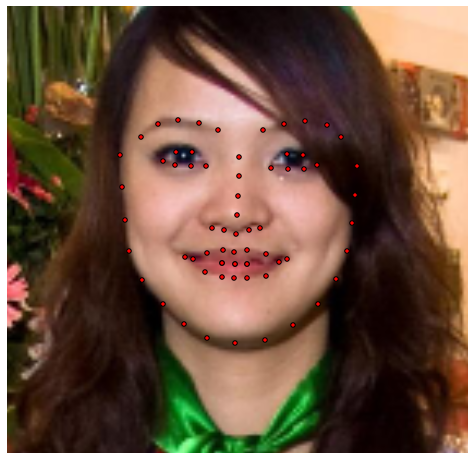

In [272]:
visualize_images(test_images)

# Active Appearance Models

## Global Warp

### Build

In [6]:
builder = GlobalAAMBuilder(features=fast_dsift, diagonal=100, 
                           scale_shapes=False, scales=(1, .5))
aam = builder.build(training_images, group='ibug_face_66', verbose=True)

- Normalizing images size: Done
- Building models
  - Level 0: Done
  - Level 1: Done


### Test

In [7]:
fitter = GlobalAAMFitter(aam, algorithm_cls=AIC, n_shape=[3, 12], 
                         n_appearance=[25, 50], sampling_step=8)

In [ ]:
np.random.seed(seed=1)

fitter_results = []

for j, i in enumerate(test_images[:]):
    
    gt_s = i.landmarks['ibug_face_66'].lms
    s = fitter.perturb_shape(gt_s, noise_std=0.05)
    
    fr = fitter.fit(i, s, gt_shape=gt_s, max_iters=20, map_inference=True)
    fr.downscale = 0.5
    
    fitter_results.append(fr)
    
    print 'Image: ', j
    print fr

### Visualize Results

In [ ]:
visualize_fitting_results(fitter_results)

### Timing

#### Total

In [ ]:
%timeit fitter.fit(i, s, gt_shape=gt_s, max_iters=20)

#### Per line

In [ ]:
import line_profiler
import IPython

ip = IPython.get_ipython()
ip.define_magic('lprun', line_profiler.magic_lprun)

In [ ]:
from alabortcvpr2015.aam import AIC

%lprun -f AIC.run fitter.fit(i, s, gt_shape=gt_s, max_iters=20)

## Local Warp

### Build

In [ ]:
builder = PartsAAMBuilder(parts_shape=(17, 17), features=fast_dsift, diagonal=100, 
                          scale_shapes=False, scales=(1, .5))
aam = builder.build(training_images, group='ibug_face_66', verbose=True)

### Test

In [ ]:
sampling_mask = np.require(np.zeros((17, 17)), dtype=np.bool)
sampling_mask[2::4, 2::4] = True

plt.imshow(sampling_mask)

In [ ]:
fitter = PartsAAMFitter(aam, algorithm_cls=AIC, n_shape=[3, 12], 
                        n_appearance=[25, 50], sampling_mask=sampling_mask)

In [ ]:
np.random.seed(seed=1)

fitter_results = []

for j, i in enumerate(test_images[:]):
    
    gt_s = i.landmarks['ibug_face_66'].lms
    s = fitter.perturb_shape(gt_s, noise_std=0.05)
    
    fr = fitter.fit(i, s, gt_shape=gt_s, max_iters=20, map_inference=False)
    fr.downscale = 0.5
    
    fitter_results.append(fr)
    
    print 'Image: ', j
    print fr

### Visualize Results

In [ ]:
visualize_fitting_results(fitter_results)

### Timing

#### Total

In [ ]:
%timeit fitter.fit(i, s, gt_shape=gt_s, max_iters=20)

#### Per line

In [ ]:
import line_profiler
import IPython

ip = IPython.get_ipython()
ip.define_magic('lprun', line_profiler.magic_lprun)

In [ ]:
from alabortcvpr2015.aam import AIC

%lprun -f AIC.run fitter.fit(i, s, gt_shape=gt_s, max_iters=20)

# Constrained Local Models

## SVM Experts

### Build

In [ ]:
from menpofast.feature import no_op, aam_dsift
from alabortcvpr2015.clm import CLMBuilder
from alabortcvpr2015.clm.classifier import LinearSVMLR 

offsets = np.meshgrid(range(-0, 1, 1), range(-0, 1, 1))
offsets = np.asarray([offsets[0].flatten(), offsets[1].flatten()]).T 

builder = CLMBuilder(parts_shape=(15, 15), features=aam_dsift2, diagonal=100, 
                     classifier=LinearSVMLR, offsets=offsets, normalize_parts=True, 
                     covariance=1, scale_shapes=False, scales=(1, .5))

clm = builder.build(training_images, group='ibug_face_66', verbose=True, 
                    threshold=0.015, dual=False, loss='l2', penalty='l1')

### Test

In [ ]:
from alabortcvpr2015.clm import CLMFitter, RLMS
                  
fitter = CLMFitter(clm, n_shape=[3, 12], scale=100000, factor=100)

In [ ]:
np.random.seed(seed=1)

fitter_results = []

for j, i in enumerate(test_images):
    
    gt_s = i.landmarks['ibug_face_66'].lms
    s = fitter.perturb_shape(gt_s, noise_std=0.04)
    
    fr = fitter.fit(i, s, gt_shape=gt_s, max_iters=20, prior=True)
    
    fitter_results.append(fr)
    fr.downscale = 0.5
    
    print 'Image: ', j
    print fr

### Visualize Results

In [ ]:
from menpofit.visualize import visualize_fitting_results
    
visualize_fitting_results(fitter_results)

### Timing

#### Total

In [ ]:
%timeit fitter.fit(i, s, gt_shape=gt_s, max_iters=20)

#### Per line

In [ ]:
import line_profiler
import IPython

ip = IPython.get_ipython()
ip.define_magic('lprun', line_profiler.magic_lprun)

In [ ]:
from alabortcvpr2015.clm import RLMS

%lprun -f RLMS.run fitter.fit(i, s, gt_shape=gt_s, max_iters=20)

## MCF Experts

### Build

In [273]:
from alabortcvpr2015.correlationfilters import learn_deep_cf, learn_mccf

builder = CLMBuilder(context_shape=(101, 101), filter_shape=(17, 17), 
                     features=no_op, diagonal=100, covariance=3, 
                     scale_shapes=False, scales=(1, .5))

clm, clfs = builder.build(training_images[:50], group='ibug_face_66', verbose=True, 
                          learn_filter=learn_mccf, l=0.1)

- Normalizing images size: Done
- Building models
  - Level 0: Done
  - Level 1: Done


In [274]:
ensemble = clm.classifiers[0]
i = test_images[0]

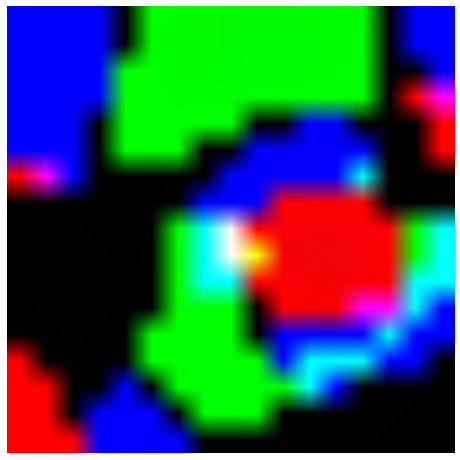

In [275]:
Image(ensemble._filter_ensemble[45]).view()

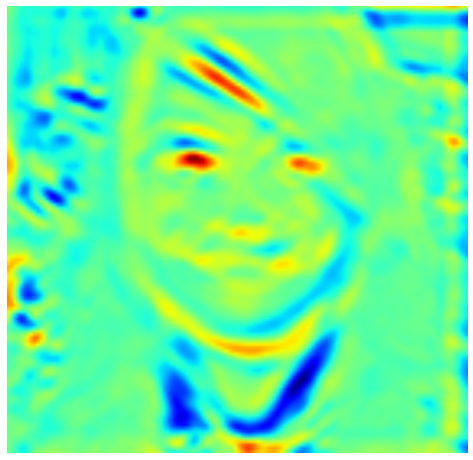

In [276]:
Image(ensemble.predict(i.pixels)[45]).view(cmap_name='jet')

In [277]:
clf = clfs[45]

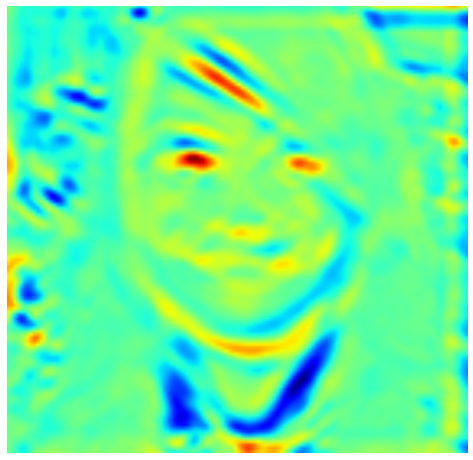

In [278]:
clf.predict(i).view(cmap_name='jet')

### Test

In [279]:
fitter = CLMFitter(clm, search_shape=(31, 31), n_shape=[3, 6], scale=1, factor=1)

In [280]:
np.random.seed(seed=1)

fitter_results = []

for j, i in enumerate(test_images):
    
    gt_s = i.landmarks['ibug_face_66'].lms
    s = fitter.perturb_shape(gt_s, noise_std=0.05)
    
    fr = fitter.fit(i, s, gt_shape=gt_s, max_iters=20, map_inference=False)
    
    fitter_results.append(fr)
    fr.downscale = 0.5
    
    print 'Image: ', j
    print fr

Image:  0
Initial error: 0.0769
Final error: 0.0614
Image:  1
Initial error: 0.1126
Final error: 0.0739
Image:  2
Initial error: 0.1649
Final error: 0.1591
Image:  3
Initial error: 0.1151
Final error: 0.1515
Image:  4
Initial error: 0.0791
Final error: 0.0583
Image:  5
Initial error: 0.0791
Final error: 0.0784
Image:  6
Initial error: 0.0635
Final error: 0.1330
Image:  7
Initial error: 0.0607
Final error: 0.1915
Image:  8
Initial error: 0.0823
Final error: 0.0481
Image:  9
Initial error: 0.1029
Final error: 0.2202


### Visualize Results

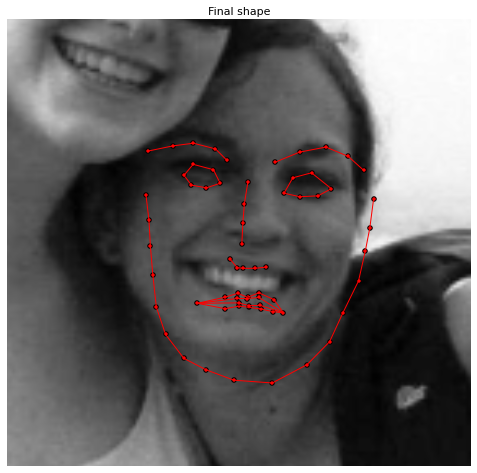

In [267]:
visualize_fitting_results(fitter_results)

### Timing

#### Total

In [80]:
%timeit fitter.fit(i, s, gt_shape=gt_s, max_iters=20)

1 loops, best of 3: 795 ms per loop


#### Per line

In [ ]:
import line_profiler
import IPython

ip = IPython.get_ipython()
ip.define_magic('lprun', line_profiler.magic_lprun)

In [ ]:
from alabortcvpr2015.clm import RLMS

%lprun -f RLMS.run fitter.fit(i, s, gt_shape=gt_s, max_iters=20)

# Unified

## Global

### Build

In [ ]:
from menpofast.feature import no_op, aam_dsift, aam_daisy
from alabortcvpr2015.unified import GlobalUnifiedBuilder
from alabortcvpr2015.clm.classifier import MCF

offsets = np.meshgrid(range(-0, 1, 1), range(-0, 1, 1))
offsets = np.asarray([offsets[0].flatten(), offsets[1].flatten()]).T 

builder = GlobalUnifiedBuilder(parts_shape=(15, 15), features=aam_dsift, diagonal=100, 
                               classifier=MCF, offsets=offsets, normalize_parts=False, 
                               covariance=2, scale_shapes=False, scales=(1, .5))

unified = builder.build(training_images, group='ibug_face_66', verbose=True)

### Test

In [ ]:
from alabortcvpr2015.unified import GlobalUnifiedFitter 
                  
fitter = GlobalUnifiedFitter(unified, n_shape=[3, 12], n_appearance=[25, 50], 
                             scale=1000, factor=10, sampling_step=8)

In [ ]:
np.random.seed(seed=1)

fitter_results = []

for j, i in enumerate(test_images):
    
    gt_s = i.landmarks['ibug_face_66'].lms
    s = fitter.perturb_shape(gt_s, noise_std=0.05)
    
    fr = fitter.fit(i, s, gt_shape=gt_s, max_iters=20, prior=True)
    
    fitter_results.append(fr)
    fr.downscale = 0.5
    
    print 'Image: ', j
    print fr

### Visualize Results

In [ ]:
from menpofit.visualize import visualize_fitting_results
    
visualize_fitting_results(fitter_results)

### Timing

#### Total

In [ ]:
%timeit fitter.fit(i, s, gt_shape=gt_s, max_iters=20)

#### Per line

In [ ]:
import line_profiler
import IPython

ip = IPython.get_ipython()
ip.define_magic('lprun', line_profiler.magic_lprun)

In [ ]:
from alabortcvpr2015.unified import ProbAIC

%lprun -f ProbAIC.run fitter.fit(i, s, gt_shape=gt_s, max_iters=20)

## Parts

### Build

In [ ]:
from menpofast.feature import no_op, aam_dsift, aam_daisy
from alabortcvpr2015.unified import PartsUnifiedBuilder
from alabortcvpr2015.clm.classifier import MCF

offsets = np.meshgrid(range(-0, 1, 1), range(-0, 1, 1))
offsets = np.asarray([offsets[0].flatten(), offsets[1].flatten()]).T 

builder = PartsUnifiedBuilder(parts_shape=(15, 15), features=aam_dsift, diagonal=100, 
                              classifier=MCF, offsets=offsets, normalize_parts=False, 
                              covariance=2, scale_shapes=False, scales=(1, .5))

unified = builder.build(training_images, group='ibug_face_66', verbose=True)

### Test

In [ ]:
sampling_mask = np.require(np.zeros((15, 15)), dtype=np.bool)
sampling_mask[1::4, 1::4] = True
#sampling_mask[:] = True

imshow(sampling_mask)

In [ ]:
from alabortcvpr2015.unified import PartsUnifiedFitter 
                  
fitter = PartsUnifiedFitter(unified, n_shape=[3, 12], n_appearance=[25, 50], 
                            scale=100000, factor=100, sampling_mask=sampling_mask)

In [ ]:
fitter._algorithms[0]._sigma2=10000
fitter._algorithms[1]._sigma2=10000
fitter._algorithms[0]._rho2=0
fitter._algorithms[1]._rho2=0

In [ ]:
np.random.seed(seed=1)

fitter_results = []

for j, i in enumerate(test_images):
    
    gt_s = i.landmarks['ibug_face_66'].lms
    s = fitter.perturb_shape(gt_s, noise_std=0.05)
    
    fr = fitter.fit(i, s, gt_shape=gt_s, max_iters=20, prior=False)
    
    fitter_results.append(fr)
    fr.downscale = 0.5
    
    print 'Image: ', j
    print fr

### Visualize Results

In [ ]:
from menpofit.visualize import visualize_fitting_results
    
visualize_fitting_results(fitter_results)

### Timing

#### Total

In [ ]:
%timeit fitter.fit(i, s, gt_shape=gt_s, max_iters=20)

#### Per line

In [ ]:
import line_profiler
import IPython

ip = IPython.get_ipython()
ip.define_magic('lprun', line_profiler.magic_lprun)

In [ ]:
from alabortcvpr2015.unified import ProbAIC

%lprun -f ProbAIC.run fitter.fit(i, s, gt_shape=gt_s, max_iters=20)